# Classifying Fashion-MNIST

직접 neural network를 정의하고 훈련하여 image 분류기를 만들어 보자.  
[Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist)을 사용한다. 이 데이터 셋은 28x28 크기의 greyscale images로 각종 의류에 대한 이미지 데이터 셋이다. 이 데이터 셋은 앞서 본 MNIST 보다는 좀 더 복잡한 패턴을 가지고 있다.
![img](../assets/fashion-mnist-sprite.png)

이 실습을 통해 각자의 neural network로 이미지 분류기를 생성한다. 앞에서 본 MNIST 분류기의 코드를 참조하여 구현할 수 있을 것이다.  

일단 필요한 패키지를 import하는 것 부터 시작해 보자.

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
%matplotlib inline

torchvision의 datasets를 통해 FasionMNIST 데이터 셋을 다운로드하고 DataLoader로 데이터를 읽어 들인다.  
- 총 10개의 class로 되어 있다.  
- class : ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

In [2]:
# Define a transform to normalize the data
transform = transforms.ToTensor()

# Download and load the training data
trainset = datasets.FashionMNIST('../data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('../data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


불러들인 이미지 데이터를 화면에 출력하여 제대로 읽어 들여졌는지 확인해 보자.

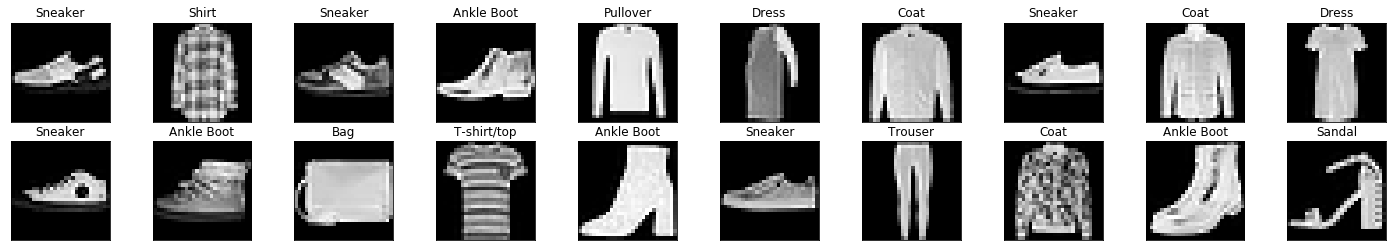

In [3]:
images, labels = next(iter(trainloader))
images = images.numpy()

class_name = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(class_name[labels[idx].item()])

## Building the network

각자만의 모형을 구현해 보자. MNIT 이미지 분류기와 유사하게 28x28 크기로 총 784 pixels의 이미지이다. 총 10개의 class로 되어 있다.  
class : ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

hidden layer의 갯수, hidden unit의 갯수, drop out의 사용여부, loss function, optimizer 등과 관련된 여러가지 설정은 개인의 판단에 따라 적절히 선택하도록 한다.

In [4]:
from torch import nn, optim
import torch.nn.functional as F

In [5]:
# TODO: Define your network architecture here
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

# Train the network

먼저 loss 함수와 optimizer를 설정한다. [criterion](http://pytorch.org/docs/master/nn.html#loss-functions)은 `nn.CrossEntropyLoss` 또는 `nn.NLLLoss`로 설정할 수 있다. 또한 [optimizer](http://pytorch.org/docs/master/optim.html) 는 `optim.SGD` 또는 `optim.Adam`로 설정 가능 하다.

모형을 훈련하기 위해 다음과 같은 사항을 고려한다:

* forward pass를 수행한다.
* loss를 계산한다.
* `loss.backward()` 로 backward pass를 수행하고 gradients를 계산한다.
* optimizer의 step으로 weights를 업데이트한다.

hidden units, learning rate... 등은 hyper parameter로 각자 알맞은 값으로 설정한다.

In [6]:
# TODO: Create the network, define the criterion and optimizer
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [7]:
# TODO: Train the network here
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()*images.size(0)
    else:
        print(f"Training loss: {running_loss/len(trainloader.dataset)}")

Training loss: 2.1759576646169028
Training loss: 1.2182665071487426
Training loss: 1.0583284123102823
Training loss: 0.7890348811467489
Training loss: 0.5176551465670268


## Test the Trained Networks
test data set으로 훈련된 모형을 평가한다. test loss와 accuracy를 확인해 본다.

In [8]:
corrects = 0
test_loss = 0

model.eval()

for images, labels in testloader:
    outputs = model(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item()*images.size(0)
    
    _, preds = torch.max(outputs, 1)
    
    corrects += torch.sum(preds == labels.data)
    
test_loss = test_loss/len(testloader.dataset)
acc = corrects.double()/len(testloader.dataset)

print("Test Loss : {:.4f}, Accuracy : {:.4f}".format(test_loss, acc))
    

Test Loss : 0.5321, Accuracy : 0.8095


## Model Prediction

훈련된 모형에 대해 test데이터를 활용하여 이미지를 분류해 보고 결과를 시각화한다.

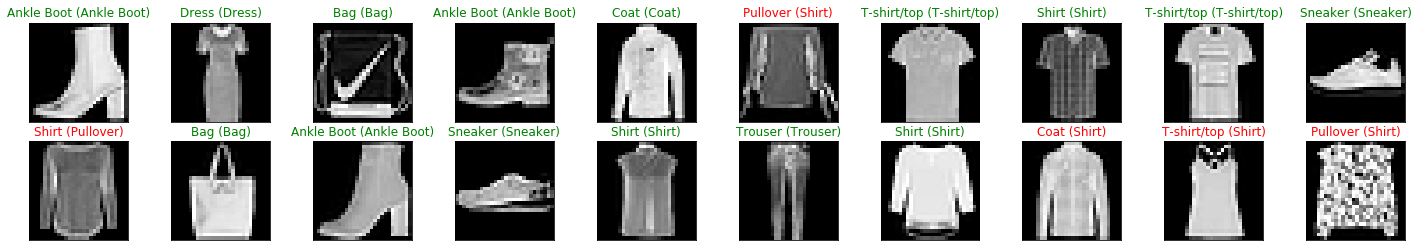

In [9]:
images, labels = next(iter(testloader))

output = model(images)

ps, preds = torch.max(output, 1)

images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(class_name[preds[idx].item()], class_name[labels[idx].item()]),
                 color=("green" if preds[idx]==labels[idx] else "red"))